### **Imports**

In [785]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [786]:
import torch
import torch.nn as nn

In [787]:
import importlib
import utils, models, training_utils
importlib.reload(utils)
importlib.reload(models)
importlib.reload(training_utils)

<module 'training_utils' from '/Users/pawelgrzeszczyk/Documents/02_studies/master/portfolio-optimization-dl/main/modeling/training_utils.py'>

### **Reading the dataset**

In [788]:
# Reading data, renaming columns and reordering
data = pd.read_csv('../data/data_files/w20_stock.csv').filter(regex='^Close_')
data.columns = [x.split('_')[1].split('.')[0] for x in data.columns]
data['Date'] = pd.read_csv('../data/data_files/w20_stock.csv')['Date']
data.insert(0, 'Date', data.pop('Date'))

# Date as index
data = data.set_index('Date')

# Getting the first row with no NaN values
first_full_row = data.dropna().first_valid_index()
print(f'First row with no NaN values is from: ({first_full_row})')

# Removing rows with NaN values
data = data.loc[first_full_row:]
print(f'Number of rows with NaN values removed: {first_full_row}')
print(f'Number of rows with no NaN values: {data.shape[0]}')

# Take only sample of assets
data = data[data.columns[:4]]
data.head()

First row with no NaN values is from: (2021-05-27)
Number of rows with NaN values removed: 2021-05-27
Number of rows with no NaN values: 792


,ALE,ALR,BDX,CDR
Date,,,,
2021-05-27,58.279999,32.900002,313.5,175.500000
2021-05-28,58.500000,33.990002,306.0,178.580002
2021-05-31,57.660000,33.740002,298.5,168.740005
2021-06-01,59.209999,34.480000,299.0,153.380005
2021-06-02,59.180000,34.410000,295.0,161.580002


In [789]:
# data, X_SEQ_LEN = utils.generate_data(end_date=datetime(2023, 1, 30),
#                                    days=100,
#                                    num_ascending_start=2,
#                                    num_descending_start=2,
#                                    swap_count=10)
# # How many "next" days should be used to set the true label
# Y_SEQ_LEN = 1

# data

### **Prepare data for the model**

**Calculating percentage changes**

In [790]:
# Calculate daily returns
data_returns = data.pct_change().dropna()

# Add new row equal to 0 - don't invest in anything
data_returns['SAVE'] = 0

print(f'Data shape: {data_returns.shape}')
data_returns.head()

Data shape: (791, 5)


,ALE,ALR,BDX,CDR,SAVE
Date,,,,,
2021-05-28,0.003775,0.033131,-0.023923,0.017550,0
2021-05-31,-0.014359,-0.007355,-0.024510,-0.055101,0
2021-06-01,0.026882,0.021932,0.001675,-0.091028,0
2021-06-02,-0.000507,-0.002030,-0.013378,0.053462,0
2021-06-04,-0.006928,0.009881,0.011864,0.059537,0


**Convert to target shape**

In [791]:
X_SEQ_LEN = 30
Y_SEQ_LEN = 1

In [792]:
import numpy as np
import torch

X_train, X_test, Y_train, Y_test = utils.create_sequences(data_returns = data_returns, 
                                                          X_seq_len = X_SEQ_LEN, 
                                                          Y_seq_len = Y_SEQ_LEN, 
                                                          test_size=0.2)

In [793]:
print(f'X shape: \n\t{X_train.shape}')
print(f'X sample: \n\t{X_train[0]}')

X shape: 
	torch.Size([608, 30, 5])
X sample: 
	tensor([[ 0.0038,  0.0331, -0.0239,  0.0175,  0.0000],
        [-0.0144, -0.0074, -0.0245, -0.0551,  0.0000],
        [ 0.0269,  0.0219,  0.0017, -0.0910,  0.0000],
        [-0.0005, -0.0020, -0.0134,  0.0535,  0.0000],
        [-0.0069,  0.0099,  0.0119,  0.0595,  0.0000],
        [ 0.0048,  0.0037, -0.0369, -0.0084,  0.0000],
        [ 0.0034, -0.0224,  0.0122,  0.0073,  0.0000],
        [ 0.0066, -0.0114,  0.0052,  0.0322,  0.0000],
        [-0.0208,  0.0110, -0.0188, -0.0142,  0.0000],
        [-0.0017, -0.0167, -0.0052,  0.0678,  0.0000],
        [ 0.0034,  0.0057,  0.0105,  0.0053,  0.0000],
        [ 0.0050, -0.0306,  0.0000,  0.0653,  0.0000],
        [ 0.0172,  0.0456, -0.0052, -0.0645,  0.0000],
        [-0.0119,  0.0246, -0.0052, -0.0276,  0.0000],
        [ 0.0162, -0.0226, -0.0123,  0.0158,  0.0000],
        [-0.0108, -0.0091,  0.0000, -0.0026,  0.0000],
        [-0.0194,  0.0209,  0.0106, -0.0305,  0.0000],
        [ 0.0343,

In [795]:
print(f'Y shape: \n\t{Y_train.shape}')
print(f'Y sample: \n\t{Y_train[0]}')

Y shape: 
	torch.Size([608, 1, 5])
Y sample: 
	tensor([[ 0.0299, -0.0476, -0.0037,  0.0737,  0.0000]])


**True labels**

| Function                  | Arguments      | Description                                                                  |
|---------------------------|----------------|------------------------------------------------------------------------------|
| `get_Y_max_one`            | `Y`            | Pick one asset with the highest returns                                       |
| `get_Y_max_light`          | `Y`            | Distribute weights among assets with positive returns depending on the returns value |
| `get_Y_sharpe_one`         | `X, Y`         | Pick one asset with the highest Sharpe ratio                                  |
| `get_Y_sharpe_light`       | `X, Y`         | Distribute weights among assets with positive returns depending on the Sharpe ratio value |

In [797]:
Y_train_true_labels = utils.get_Y_sharpe_light(X_train, Y_train)
Y_test_true_labels = utils.get_Y_sharpe_light(X_test, Y_test)

print(f'Y_true_labels shape: \n\t{Y_true_labels.shape}')
print(f'Y_true_labels sample: \n\t{Y_true_labels[0]}')

Y_true_labels shape: 
	torch.Size([72, 5])
Y_true_labels sample: 
	tensor([0.8247, 0.1753, 0.0000, 0.0000, 0.0000])


### **Model**

In [798]:
input_size = X_train.shape[2]
hidden_size = 256
output_size = Y_true_labels.shape[1]

# Create the model
lstm_model = models.LSTMModel(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size=output_size,
                  num_layers=2).to()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-4)

### **Training**

In [802]:
next(lstm_model.parameters()).is_cuda

False

In [799]:
model_results = training_utils.train(
                    model=lstm_model,
                    X_train=X_train,
                    Y_train=Y_train,
                    Y_train_true_labels=Y_train_true_labels,
                    X_test=X_test,
                    Y_test=Y_test,
                    Y_test_true_labels=Y_test_true_labels,
                    optimizer=optimizer,
                    criterion=criterion,
                    profit_calc_fn=utils.calculate_portfolio_return,
                    epochs=1000,
                    print_every=100)

KeyboardInterrupt: 

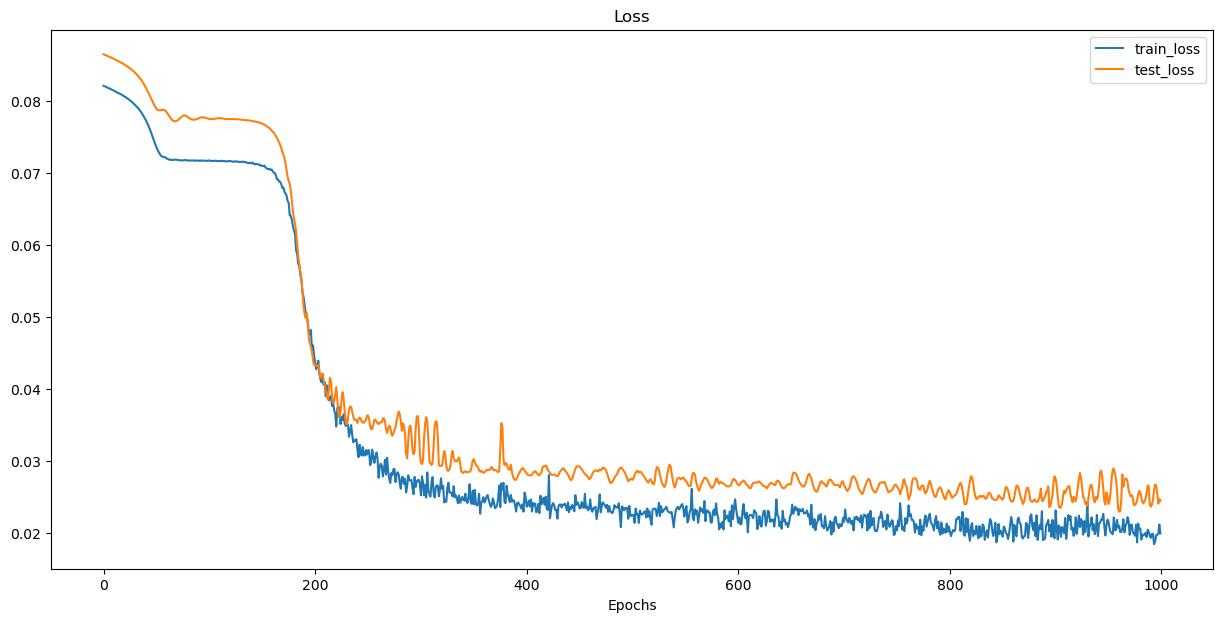

In [748]:
utils.plot_loss_curves(model_results)

### **Evaluation**

### **Profit calculation**

In [749]:
max_daily_returns, max_total_returns = utils.calculate_max_return(Y_test)

print(f'Total max returns: {max_total_returns}')
print(f'Daily max returns: {max_daily_returns}')

Total max returns: 2.3608474731445312
Daily max returns: tensor([1.0870, 1.0134, 1.0801, 1.0607, 1.0618, 1.0183, 1.0858, 1.0689, 1.0682,
        1.0434, 1.0857, 1.0884, 1.0729, 1.0636, 1.0869, 1.0887, 1.0889, 1.0957])


In [750]:
portfolio_daily_returns, portfolio_total_returns = utils.calculate_portfolio_return(output_weights, Y_test)

print(f'Total portfolio returns: {portfolio_total_returns}')
print(f'Daily portfolio returns: {portfolio_daily_returns}')

Total portfolio returns: 1.4015896320343018
Daily portfolio returns: tensor([1.0731, 1.0064, 1.0503, 1.0330, 1.0357, 1.0170, 1.0686, 1.0534, 1.0555,
        1.0349, 1.0723, 1.0780, 1.0360, 1.0461, 1.0533, 1.0756, 1.0661, 1.0456])


In [762]:
print(f'Earned profit vs max profit: {portfolio_total_returns:.2f}% vs {max_total_returns:.2f}%')

Earned profit vs max profit: 1.40% vs 2.36%
